In [39]:
## Lbraries
import numpy as np
from numba import njit
import scipy

In [40]:
## Load data
import tarfile as tr
fil = tr.open("cifar-10-python.tar.gz")
fil.extractall()
fil.close()

In [41]:
## Data Loading
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dict1 = unpickle(f"cifar-10-batches-py/data_batch_1")
dict2 = unpickle(f"cifar-10-batches-py/data_batch_2")
dict3 = unpickle(f"cifar-10-batches-py/data_batch_3")
dict4 = unpickle(f"cifar-10-batches-py/data_batch_4")
dict5 = unpickle(f"cifar-10-batches-py/data_batch_5")
dict_test = unpickle(f"cifar-10-batches-py/test_batch")

In [42]:
## dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
## 0 to 1023 First channel RED
## 1023 to 2047 Second channel GREEN
## 2047 to 3071 Third channel BLUE

## concatenate data
train_X = np.concatenate((dict1[b'data'], dict2[b'data'],dict3[b'data'],dict4[b'data'],dict5[b'data']), axis=0)
train_Y = np.concatenate((dict1[b'labels'], dict2[b'labels'],dict3[b'labels'],dict4[b'labels'],dict5[b'labels']), axis=0)
test_X = np.array(dict_test[b'data'])
test_Y = np.array(dict_test[b'labels'])

In [43]:
def slided_matrix(x, y_shape, kernel, stride=1):
    working_input = x
    
    _, _, out_h, out_w = y_shape
    out_b, in_c, _, _ = x.shape
    batch_str, channel_str, kern_h_str, kern_w_str = working_input.strides

    A =  np.lib.stride_tricks.as_strided(
        working_input,
        (out_b, in_c, out_h, out_w, kernel.shape[2], kernel.shape[2]),
        (batch_str, channel_str, stride * kern_h_str, stride * kern_w_str, kern_h_str, kern_w_str))
    return (np.einsum('siabkl,oikl->soab',A,kernel), A)

def fullconvolve(de_dy,X,K,B,prev_windows):
    de_dw = np.einsum('sihwkl,sohw->oikl',prev_windows,de_dy)
    de_db = np.zeros(B.shape)
    k = K.shape[2]
    de_dy_1 = np.pad(de_dy,((0,0),(0,0),(k-1,k-1),(k-1,k-1)),constant_values=0)
    new_K = np.rot90(K,2,(2,3))
    (a,b,c,d) = de_dy_1.shape ## input
    (e,f,g,h) = new_K.shape ## kernel
    (i,j,k,l) = X.shape ## output
    (p,q,r,s) = de_dy_1.strides
    output_1 = np.lib.stride_tricks.as_strided(
        de_dy_1,
        (a,b,k,l,g,g),
        (p,q,r,s,r,s)
    )
    de_dx = np.einsum('sohwkl,oikl->sihw',output_1,new_K)
    
    return (de_dw,de_db,de_dx)  
        
    


In [44]:
a = np.ones((4,4,4,4))
b = np.ones(())


In [45]:
def maxpool(x, shape):
    windows = np.lib.stride_tricks.as_strided(x,shape,axis=(2,3), strides=2)
    maxpool = np.max(windows, axis=(4,5))
    return maxpool
def relu(x):
    return x * (x > 0)
def pad(x):
    return np.pad(x, pad_width=1, constant_values=0)
def flatten(x):
    return x.reshape(-1)
def convolve(x, w):
    windows = np.lib.stride_tricks.sliding_window_view(x, w.shape)
    A = np.einsum('ij,klij->kl',w,windows)
    return A
def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)  

In [48]:
##dataload
train_X = train_X.reshape(-1,3,32,32) 
train_X = train_X/255
L = np.zeros((len(train_X),10))
for i in range(len(train_Y)):
    L[i] = np.eye(10)[train_Y[i]]
train_Y = L
print(train_Y.shape)

(50000, 10)


In [49]:
print(train_X.shape)
print(train_Y.shape)

(50000, 3, 32, 32)
(50000, 10)


In [50]:
## helper :
def soft_max(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

def rotatefullconvolve(x, w):
    f = w.copy()
    j = x.copy()
    j = np.pad(j,pad_width=w.shape[0]-1,constant_values=0)
    f = np.rot90(f, 2)
    windows = np.lib.stride_tricks.sliding_window_view(j, w.shape)
    A = np.einsum('ij,klij->kl',f,windows)
    return A


In [51]:
import numpy as np
a = np.ones((3,3,3,3))
a = a/5
print(a)

[[[[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]

  [[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]

  [[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]]


 [[[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]

  [[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]

  [[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]]


 [[[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]

  [[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]

  [[0.2 0.2 0.2]
   [0.2 0.2 0.2]
   [0.2 0.2 0.2]]]]


In [89]:
class Model:
    def __init__(self,batchsize) -> None:
        self.learning_rate = 0.001
        self.beta1 = 0.9
        self.beta2 = 0.99
        self.epsilon = 1e-8
        self.windows1 = None
        self.windows2 = None
        self.windows3 = None
        
        self.batchsize = batchsize
        init1 = np.sqrt(6/(32*3))
        self.K1 = np.random.normal(0,init1,(32,3,3,3))
        self.K1[0][0] = np.random.randn(self.K1.shape[2],self.K1.shape[3])
        self.K1[0][1] = np.random.randn(self.K1.shape[2],self.K1.shape[3])
        self.K1[0][2] = np.random.randn(self.K1.shape[2],self.K1.shape[3])
        self.B1 = np.zeros((32,32,32))
        self.ADAm1 = np.zeros((32,3,3,3))
        self.ADAv1 = np.zeros((32,3,3,3))
        self.ADAm1_bias = np.zeros((32,32,32))
        self.ADAv1_bias = np.zeros((32,32,32))
        
        
        self.Y1 = np.zeros((batchsize,32,32,32)) ##### INPUT FOR RELU
        self.RELUY1 = np.zeros((batchsize,32,32,32)) #### INPUT FOR MAXPOOL
        self.M1mask = np.zeros((batchsize,32,32,32)) #### MASK FOR MAXPOOL1
        self.M1 = (2,2) # stride 2
        # Now input is 5000x32(outchannels)x16x16
        self.MY1 = np.zeros((batchsize,32,16,16)) #### INPUT FOR CONVOLUTION
        init2 = np.sqrt(1/(64*32))
        self.K2 = np.random.normal(0,init2,(64,32,5,5))
        self.B2 = np.zeros((64,14,14))
        self.ADAm2 = np.zeros((64,32,5,5))
        self.ADAv2 = np.zeros((64,32,5,5))
        self.ADAm2_bias = np.zeros((64,14,14))
        self.ADAv2_bias = np.zeros((64,14,14))
        
        
        self.Y2 = np.zeros((batchsize,64,14,14)) ##### INPUT FOR RELU
        self.RELUY2 = np.zeros((batchsize,64,14,14)) #### INPUT FOR MAXPOOL
        self.M2mask = np.zeros((batchsize,64,14,14)) #### MASK FOR MAXPOOL2
        self.M2 = (2,2)
        # Now input is 5000x32x7x7
        self.MY2 = np.zeros((batchsize,64,7,7)) #### INPUT FOR CONVOLUTION
        init3 = np.sqrt(1/(64*64))
        self.K3 = np.random.normal(0,init3,(64,64,3,3))
        self.B3 = np.zeros((64,7,7))
        self.ADAm3 = np.zeros((64,64,3,3))
        self.ADAv3 = np.zeros((64,64,3,3))
        self.ADAm3_bias = np.zeros((64,7,7))
        self.ADAv3_bias = np.zeros((64,7,7))
        
        
        
        self.Y3 = np.zeros((batchsize,64,7,7)) ### INPUT FOR RELU
        self.RELUY3 = np.zeros((batchsize,64,7,7)) ## INPUT FOR FLATTEN
        self.flat1 = np.zeros((batchsize,64*7*7)) ## INPUT FOR FC
        # Now input is 7x7 and 64 channels
        init4 = np.sqrt(1/64*64*7*7)
        self.FCW1 = np.random.normal(0,init4,(64,64*7*7))
        self.FCB1 = np.ones((64,1))
        self.ADAFCm1 = np.zeros((64,64*7*7))
        self.ADAFCv1 = np.zeros((64,64*7*7))
        self.ADAFCm1_bias = np.zeros((64,1))
        self.ADAFCv1_bias = np.zeros((64,1))
        
        
        
        
        self.YFC1 = np.zeros((batchsize,64)) ### INPUT FOR RELU
        self.RELUY4 = np.zeros((batchsize,64)) ### INPUT FOR FC
        
        init5 = np.sqrt(1/(64*10))
        self.FCW2 = np.random.normal(0,init5,(10,64))
        self.FCB2 = np.ones((10,1))
        self.ADAFCm2 = np.zeros((10,64))
        self.ADAFCv2 = np.zeros((10,64))
        self.ADAFCm2_bias = np.zeros((10,1))
        self.ADAFCv2_bias = np.zeros((10,1))
        
        
        self.YFC2 = np.zeros((batchsize,10)) ### INPUT FOR SOFTMAX
        
        
        ## Gradients of Weights
        self.K1_grad = np.zeros((32,3,3,3))
        self.K2_grad = np.zeros((64,32,5,5))
        self.K3_grad = np.zeros((64,64,3,3))
        self.FCW1_grad = np.zeros((64,64*7*7))
        self.FCW2_grad = np.zeros((10,64))
        
        ## Gradients of Biases
        self.B1_grad = np.zeros((32,32,32))
        self.B2_grad = np.zeros((64,14,14))
        self.B3_grad = np.zeros((64,7,7))
        self.FCB1_grad = np.zeros((64,1))
        self.FCB2_grad = np.zeros((10,1))
        
        
        
        
    def pad_layer(self,X):
        A = np.pad(X, pad_width=((0,0),(0,0),(1,1),(1,1)), constant_values=0)
        return A
    
    def conv_layer(self, X, K, B, Y):
        return slided_matrix(X,Y.shape,K,1)
       
    
    def rel_layer(self,X):
        foo = np.vectorize(relu)
        return foo(X)
    
   
    def maxpool_layer(self, X, M):
        _,a,b,_ = X.shape
        windows = b//2
        pool= X.reshape((self.batchsize, a, windows, 2,windows,2))
        maxp = pool.max(axis=(3,5))
        maskgrad = maxp.repeat(2, axis=3).repeat(2, axis=2)
        fin_mask = np.where(np.equal(maskgrad, X)==True, 1, 0)
        return (maxp, fin_mask)                    
    
    def flatten_layer(self,X):
        return X.reshape(self.batchsize,-1)
    
    def fc_layer(self, X, W, B):
        return np.add(np.dot(W,X.T),np.repeat(B,self.batchsize,axis=1)).T
      
    
    def softmax_layer(self,X):
        for i in range(len(X)):
            X[i] = soft_max(X[i]) ## samples
        return X
         
    def cross_entropy_layer(self,y_true, y_pred):
        return -np.sum(np.multiply(y_true,np.log(y_pred)))  
    
    
    def softmax_backprop(self, soft_output, Y_true):
        de_dy = np.zeros(soft_output.shape)
        for i in range(len(soft_output)):
            de_dy[i] = np.subtract(soft_output[i], Y_true[i])
        return de_dy
        
    
    def fc_backprop(self,de_dy, X, W, B):

        ## weight 
        de_dw = np.dot(de_dy.T,X)
        ## bias 
        de_db = np.reshape(np.sum(de_dy,axis=0),(B.shape))
        ## input
        de_dx = np.dot(de_dy,W)
        return (de_dw, de_db, de_dx)      
    
    def maxpool_mask(self, X):
        pass 

    def maxpool_backprop(self, de_dy, mask): ## de_dy= 5000x32x16x16, X=5000x32x32x32, mask=5000x32x16x16
        return np.multiply(mask, de_dy.repeat(2, axis=3).repeat(2, axis=2))

    
    
    def relu_backprop(self,de_dy, X):
        P = np.where(X > 0, 1 ,0)
        P = np.multiply(P, de_dy)
        return P
    

    

    def conv_backprop(self,de_dy, X, K, B, prev_windows):
        return fullconvolve(de_dy,X,K,B,prev_windows)
        
        
        
       
    def flatten_backprop(self,de_dy, X):
        return de_dy.reshape(X.shape)
    
    
    def forward(self, X, debug):
        X = self.pad_layer(X) ## input padded
        Y = np.zeros((len(X),(self.K1.shape[0]),32,32)) 
        A = self.conv_layer(X, self.K1, self.B1, Y) 
        X = A[0]
        self.windows1 = A[1]
        self.Y1 = X.copy()
        
        if debug:
            print("output after first cnn layer")
            print(self.Y1)
            print("Kernel of cnn layer 1")
            print(self.K1)
        
        X = self.rel_layer(X)
        self.RELUY1 = X.copy()
        
        X = self.maxpool_layer(X, self.M1)
        self.MAXY1 = X[0].copy()
        self.M1mask = X[1].copy()
        
        X = self.pad_layer(X[0])
        
        a,b,c = self.B2.shape
        Y = np.zeros((len(X),a,b,c))
        A = self.conv_layer(X, self.K2, self.B2, Y)
        X = A[0]
        self.windows2 = A[1]
        self.Y2 = X.copy()
        
        if debug:
            print("output after 2 cnn layer")
            print(self.Y2)
            print("Kernel of cnn layer 2")
            print(self.K2)
        
        X = self.rel_layer(X)
        self.RELUY2 = X.copy()
        
        X = self.maxpool_layer(X, self.M2)
        self.MAXY2 = X[0].copy()
        self.M2mask = X[1].copy()
        
        X = self.pad_layer(X[0])
        
        a,b,c = self.B3.shape
        Y = np.zeros((len(X),a,b,c))
        A = self.conv_layer(X, self.K3, self.B3, Y)
        X = A[0]
        self.windows3 = A[1]
        self.Y3 = X.copy()
        
        if debug:
            print("output after 3 cnn layer")
            print(self.Y3)
            print("Kernel of cnn layer 3")
            print(self.K3)
        
        X = self.rel_layer(X)
        self.RELUY3 = X.copy()
        
        
        
        X = self.flatten_layer(X)
        self.flat1 = X.copy()
        
        X = self.fc_layer(X, self.FCW1, self.FCB1)
        self.YFC1 = X.copy()
        
        if debug:
            print("output after first fc layer")
            print(self.YFC1)
            print("Kernel of fc layer 1")
            print(self.FCW1)
        
        X = self.rel_layer(X)
        self.RELUY4 = X.copy()
        
        X = self.fc_layer(X, self.FCW2, self.FCB2)
        self.YFC2 = X.copy()
        
        if debug:
            print("output after second fc layer")
            print(self.YFC1)
            print("Kernel of fc layer 2")
            print(self.FCW1)
        
        X = self.softmax_layer(X)
        
        if debug:
            print("Final output")
            print(X)

        return X
    
    
    def backward(self, Y_pred, Y, input_X): ## X :- Forward returned
        # print(Y_pred)
        
        de_dy = self.softmax_backprop(Y_pred, Y) ## on layer after fc2

        (a, b, de_dy) = self.fc_backprop(de_dy, self.RELUY4, self.FCW2, self.FCB2) ## on layer after fc1
        
        self.FCW2_grad = a.copy()
        self.FCB2_grad = b.copy()

        de_dy = self.relu_backprop(de_dy, self.YFC1) ## on layer after fc1
        
        
        
        (self.FCW1_grad, self.FCB1_grad, de_dy) = self.fc_backprop(de_dy, self.flat1, self.FCW1, self.FCB1) ## on layer after flatten                
        
        de_dy = self.flatten_backprop(de_dy, self.RELUY3) ## on layer after conv3
        
        de_dy = self.relu_backprop(de_dy, self.Y3) ## on layer after conv3
        
        (self.K3_grad, self.B3_grad, de_dy) = self.conv_backprop(de_dy, self.pad_layer(self.MAXY2), self.K3, self.B3,self.windows3) ## on layer after maxpool2
        
        de_dy = de_dy[:,:,1:-1,1:-1]
        de_dy = self.maxpool_backprop(de_dy, self.M2mask) ## on layer after maxpool2
        
        de_dy = self.relu_backprop(de_dy, self.Y2) ## on layer after conv2
        
        (self.K2_grad, self.B2_grad, de_dy) = self.conv_backprop(de_dy, self.pad_layer(self.MAXY1), self.K2, self.B2, self.windows2) ## on layer after maxpool1
        
        de_dy = de_dy[:,:,1:-1,1:-1]
        de_dy = self.maxpool_backprop(de_dy, self.M1mask) ## on layer after maxpool1
        
        de_dy = self.relu_backprop(de_dy, self.Y1) ## on layer after conv1
        
        (self.K1_grad, self.B1_grad, de_dy) = self.conv_backprop(de_dy, self.pad_layer(input_X), self.K1, self.B1, self.windows1) ## on layer after input
        
        return
    
    def update(self, t, m1, v1, m1_bias, v1_bias, w_grad, b_grad, w, b):
        m1 = self.beta1 * m1 + (1-self.beta1) * w_grad
        v1 = self.beta2 * v1 + (1-self.beta2) * (w_grad**2)
        m1_bias = self.beta1 * m1_bias + (1-self.beta1) * b_grad
        v1_bias = self.beta2 * v1_bias + (1-self.beta2) * (b_grad**2)
        m1_hat = m1 / (1 - self.beta1**t)
        v1_hat = v1 / (1 - self.beta2**t)
        m1_bias_hat = m1_bias / (1 - self.beta1**t)
        v1_bias_hat = v1_bias / (1 - self.beta2**t)
        w = w - self.learning_rate * m1_hat / (np.sqrt(v1_hat) + self.epsilon)
        b = b - self.learning_rate * m1_bias_hat / (np.sqrt(v1_bias_hat) + self.epsilon)
        return (m1,v1,m1_bias, v1_bias, w_grad, b_grad, w, b)
        

    def adam_optimize(self, learning_rate, beta1, beta2, epsilon, t):
        (self.ADAm1, self.ADAv1, self.ADAm1_bias, self.ADAv1_bias, self.K1_grad, self.B1_grad, self.K1, self.B1) = self.update(t, self.ADAm1, self.ADAv1, self.ADAm1_bias, self.ADAv1_bias, self.K1_grad, self.B1_grad, self.K1, self.B1)
        (self.ADAm2, self.ADAv2, self.ADAm2_bias, self.ADAv2_bias, self.K2_grad, self.B2_grad, self.K2, self.B2) = self.update(t, self.ADAm2, self.ADAv2, self.ADAm2_bias, self.ADAv2_bias, self.K2_grad, self.B2_grad, self.K2, self.B2)
        (self.ADAm3, self.ADAv3, self.ADAm3_bias, self.ADAv3_bias, self.K3_grad, self.B3_grad, self.K3, self.B3) = self.update(t, self.ADAm3, self.ADAv3, self.ADAm3_bias, self.ADAv3_bias, self.K3_grad, self.B3_grad, self.K3, self.B3)
        (self.ADAFCm1, self.ADAFCv1, self.ADAFCm1_bias, self.ADAFCv1_bias, self.FCW1_grad, self.FCB1_grad, self.FCW1, self.FCB1) = self.update(t, self.ADAFCm1, self.ADAFCv1, self.ADAFCm1_bias, self.ADAFCv1_bias, self.FCW1_grad, self.FCB1_grad, self.FCW1, self.FCB1)
        (self.ADAFCm2, self.ADAFCv2, self.ADAFCm2_bias, self.ADAFCv2_bias, self.FCW2_grad, self.FCB2_grad, self.FCW2, self.FCB2) = self.update(t, self.ADAFCm2, self.ADAFCv2, self.ADAFCm2_bias, self.ADAFCv2_bias, self.FCW2_grad, self.FCB2_grad, self.FCW2, self.FCB2)
        return
    
    def train(self, X, Y, epochs):
        batch = self.batchsize
        for i in range(epochs):
            print(f"This is Epoch Number : {i+1}")
            train_loss = 0
            for j in range((1000)):
                    X_batch = X[j*batch:(j+1)*batch]
                    Y_batch = Y[j*batch:(j+1)*batch]
                    Y_pred = self.forward(X_batch,debug=False)
                    self.backward(Y_pred, Y_batch, X_batch)
                    self.adam_optimize(self.learning_rate, self.beta1, self.beta2, self.epsilon, i+1)
                    train_loss += self.cross_entropy_layer(Y_batch, Y_pred)
            print("Train Loss after epoch ", i+1, " is ", train_loss)    
            val_sum = 0
            acc = 0
            count = 0
            val_loss = 0
            for j in range((30)):
                    X_batch = X[(1200+j)*batch:(1200+j+1)*batch]
                    Y_batch = Y[(1200+j)*batch:(1200+j+1)*batch]
                    Y_pred = self.forward(X_batch,debug=False)
                    val_sum += self.cross_entropy_layer(Y_batch, Y_pred)
                    f1 = np.argmax(Y_pred, axis=1)
                    f2 = np.argmax(Y_batch, axis=1)
                    f =  np.where(f1==f2,1,0)
                    f = np.sum(f)
                    count += batch
                    acc += f
            print("Validation Accuracy after epoch ", i+1, " is ", acc/count)
            print("Validation Loss after epoch ", i+1, " is ", val_sum)  
            print(f"SUM of weights after epoch {i+1} : ", np.sum(self.K1))
            print(f"SUM of weights after epoch {i+1}: ", np.sum(self.K2))
            print(f"SUM of weights after epoch {i+1}: ", np.sum(self.K3))
            print(f"SUM of weights after epoch {i+1}: ", np.sum(self.FCW1))
            print(f"SUM of weights after epoch {i+1}: ", np.sum(self.FCW2))
        print("FINDING CLASS ACCURACY")
        L = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
        for j in range((30)):
                X_batch = X[(1200+j)*batch:(1200+j+1)*batch]
                Y_batch = Y[(1200+j)*batch:(1200+j+1)*batch]
                Y_pred = self.forward(X_batch,debug=False)
                for i in range(batch):
                    p1 = np.argmax(Y_pred[i])
                    p2 = np.argmax(Y_batch[i])
                    if p1 == p2 :
                        L[p1][0] += 1
                        L[p1][1] += 1
                    else:
                        L[p2][1] += 1
        print("This is class wise accuracy : ")
        print(L)
                    
        return
    

In [83]:
a = [[1,2,3],[4,5,6],[15,8,9],[6,7,8]]
a = np.array(a)
print(a)
a = np.argmax(a,axis=1)
print(a)

[[ 1  2  3]
 [ 4  5  6]
 [15  8  9]
 [ 6  7  8]]
[2 2 0 2]


In [90]:
mymodel = Model(32)
mymodel.train(train_X, train_Y, 10)   

This is Epoch Number : 1
Train Loss after epoch  1  is  57552.367827032904
Validation Accuracy after epoch  1  is  0.4583333333333333
Validation Loss after epoch  1  is  1432.5318389946685
SUM of weights after epoch 1 :  -11.889195417979447
SUM of weights after epoch 1:  -403.60810284119015
SUM of weights after epoch 1:  -123.00504502258525
SUM of weights after epoch 1:  -3578.4338536178143
SUM of weights after epoch 1:  -2.4322683066608386
This is Epoch Number : 2
Train Loss after epoch  2  is  44869.55851132419
Validation Accuracy after epoch  2  is  0.5239583333333333
Validation Loss after epoch  2  is  1295.9599934153584
SUM of weights after epoch 2 :  -12.988625830442695
SUM of weights after epoch 2:  -510.76656193395405
SUM of weights after epoch 2:  -133.43849165115137
SUM of weights after epoch 2:  -3354.8530726853346
SUM of weights after epoch 2:  -5.353190730915161
This is Epoch Number : 3
Train Loss after epoch  3  is  40239.235533264495
Validation Accuracy after epoch  3  i

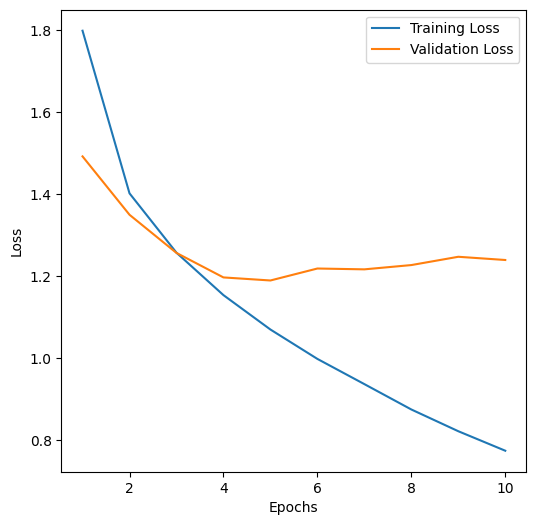

In [5]:
import numpy as np
loss_t = [ 57552.367827032904, 44869.55851132419, 40239.235533264495, 36932.01980692449,  34249.347035700885,  31957.707067972366, 29991.495367568845, 28012.682490831812,  26316.996381523208,  24796.51841563519]
loss_t = np.array(loss_t)/32000
loss_v = [1432.5318389946685,  1295.9599934153584, 1206.6829972069454, 1149.3626453035192, 1142.2079051252722, 1170.2084989690588, 1168.258427333786, 1178.2692606691762, 1197.664212056381,  1190.1363301194135]
loss_v = np.array(loss_v)/960
# Make a list of validation accuracies from above output
val_acc = [0.4583333333333333,  0.5239583333333333,  0.55625,  0.5864583333333333, 0.5927083333333333,  0.5885416666666666, 0.590625, 0.6072916666666667, 0.6010416666666667, 0.6104166666666667]
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
x_label = [i for i in range(1,11)]
y_label = loss_t

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x_label, y_label, label = "Training Loss")
plt.plot(x_label, loss_v, label = "Validation Loss")
plt.legend()
plt.show()


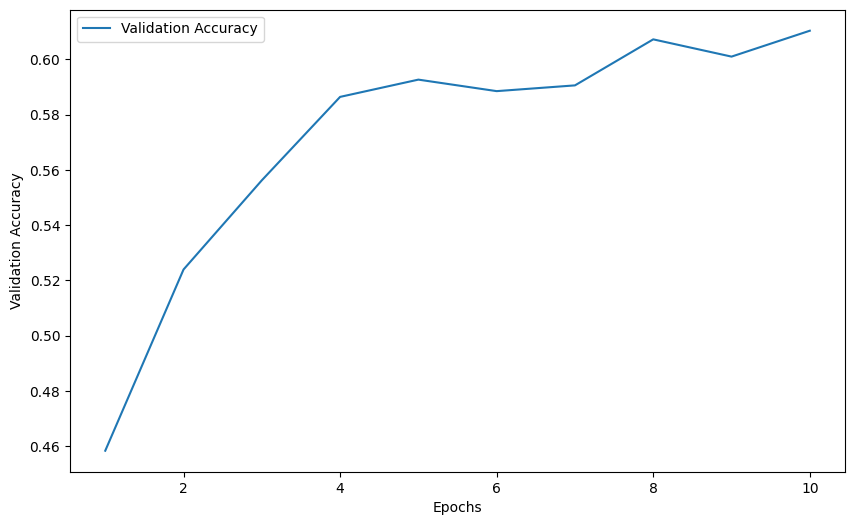

In [8]:
import numpy as np
loss_t = [ 57552.367827032904, 44869.55851132419, 40239.235533264495, 36932.01980692449,  34249.347035700885,  31957.707067972366, 29991.495367568845, 28012.682490831812,  26316.996381523208,  24796.51841563519]
loss_t = np.array(loss_t)/32000
loss_v = [1432.5318389946685,  1295.9599934153584, 1206.6829972069454, 1149.3626453035192, 1142.2079051252722, 1170.2084989690588, 1168.258427333786, 1178.2692606691762, 1197.664212056381,  1190.1363301194135]
loss_v = np.array(loss_v)/960
# Make a list of validation accuracies from above output
val_acc = [0.4583333333333333,  0.5239583333333333,  0.55625,  0.5864583333333333, 0.5927083333333333,  0.5885416666666666, 0.590625, 0.6072916666666667, 0.6010416666666667, 0.6104166666666667]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
x_label = [i for i in range(1,11)]
y_label = loss_t

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(x_label, val_acc, label = "Validation Accuracy")
plt.legend()
plt.show()


In [9]:
l = [[67, 99], [68, 95], [41, 85], [24, 99], [44, 95], [40, 93], [78, 107], [69, 100], [92, 115], [63, 82]]
l = np.array(l)
l1 = []
for tu in l:
    a,b = tu
    tu = a/b
    l1.append(tu)
print(l1)

[0.6767676767676768, 0.7157894736842105, 0.4823529411764706, 0.24242424242424243, 0.4631578947368421, 0.43010752688172044, 0.7289719626168224, 0.69, 0.8, 0.7682926829268293]


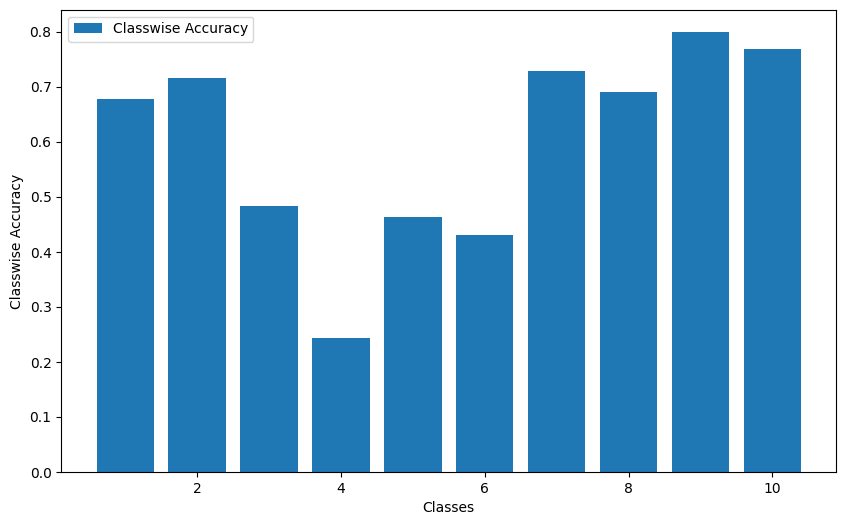

In [12]:
import numpy as np
loss_t = [ 57552.367827032904, 44869.55851132419, 40239.235533264495, 36932.01980692449,  34249.347035700885,  31957.707067972366, 29991.495367568845, 28012.682490831812,  26316.996381523208,  24796.51841563519]
loss_t = np.array(loss_t)/32000
loss_v = [1432.5318389946685,  1295.9599934153584, 1206.6829972069454, 1149.3626453035192, 1142.2079051252722, 1170.2084989690588, 1168.258427333786, 1178.2692606691762, 1197.664212056381,  1190.1363301194135]
loss_v = np.array(loss_v)/960
# Make a list of validation accuracies from above output
val_acc = [0.4583333333333333,  0.5239583333333333,  0.55625,  0.5864583333333333, 0.5927083333333333,  0.5885416666666666, 0.590625, 0.6072916666666667, 0.6010416666666667, 0.6104166666666667]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
x_label = [i for i in range(1,11)]
y_label = loss_t
l1 = [0.6767676767676768, 0.7157894736842105, 0.4823529411764706, 0.24242424242424243, 0.4631578947368421, 0.43010752688172044, 0.7289719626168224, 0.69, 0.8, 0.7682926829268293]
plt.xlabel("Classes")
plt.ylabel("Classwise Accuracy")
plt.bar(x_label, l1, label = "Classwise Accuracy")
plt.legend()
plt.show()


In [18]:
X = np.ones((100,64,7,7))
Y = np.pad(X, pad_width=((0,0),(0,0),(1,1),(1,1)), constant_values=0)

In [14]:
import numpy as np
a = np.ones(4)
print(a.shape)
b = np.ndarray([1,1,1,1]).T
print("fr")
print(b.shape)



(4,)
fr
(1, 1, 1, 1)


In [31]:
a = np.ones((1,3))
b = np.ones((1,3))
print(np.dot(a,b.T))

[[3.]]


In [29]:
a = [1,2,3]
b = [1,2,3]
a = np.array(a)
b = np.array(b)
print(np.dot(a,b.T))


14


In [38]:
a = np.ones((3,1))
b = np.ones((3,1))
h = np.multiply(a,b)
print(h.shape)


(3, 1)


In [41]:
a = np.ones((3,1))
b = 2*a
print(b.shape)

(3, 1)


In [68]:
print(train_X[0][0])

[[ 59  43  50 ... 158 152 148]
 [ 16   0  18 ... 123 119 122]
 [ 25  16  49 ... 118 120 109]
 ...
 [208 201 198 ... 160  56  53]
 [180 173 186 ... 184  97  83]
 [177 168 179 ... 216 151 123]]


In [57]:
a = np.ones((3,2))
print(a)
b = (np.sum(a,axis=0))
b = np.reshape(b,(-1,1))
print(b)


[[1. 1.]
 [1. 1.]
 [1. 1.]]
[[3.]
 [3.]]


In [37]:
A = np.random.randint(0, 100, (10, 10))
print(A)

[[78 88 61 54 75 10 73 24 56 26]
 [89 64 30 10 12 41 52 76 82 81]
 [ 6 73 26 36 64  7 73 12 60 80]
 [45 91 27 75 86 31 98 32 52 33]
 [68 46  5  3 70 19 93  2 62 13]
 [41 60 79 57 40 24 20 84 90 73]
 [45 76 80 58 44 25 23 80 56 93]
 [31 70 89 39 11 87 70 66 90 83]
 [23 80 87 49 89 17 74 51  7 68]
 [84 10 25 64 14 98 86 38 27 85]]


[[89 61 75 76 82]
 [91 75 86 98 80]
 [68 79 70 93 90]
 [76 89 87 80 93]
 [84 87 98 86 85]]


In [45]:


a = np.ones((3,1))
b = np.repeat(a, 3, axis=1)
print(b)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [64]:
x = np.array([[1,2],[3,4]])
print(np.where(x > 2, 1, 0, axis=(0,1)))

TypeError: where() got an unexpected keyword argument 'axis'

In [67]:
x = np.random.randint(0, 100, (10, 10, 10, 10))
windows = np.lib.stride_tricks.sliding_window_view(x,(2,2),axis=(2,3))
maxpool = np.max(windows, axis=(4,5))

In [71]:
a = np.ones((3,3,3))
b = a-a
print(b)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [72]:
b = np.ones((50,3,3))
t = [9,12,14,15]
c = b[t]
print(c)

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


In [45]:
import scipy
in1 = np.ones((10,10))
in2 = np.ones((5,5))

A = scipy.signal.correlate2d(in1, in2, mode='full')
print(A.shape)

(14, 14)


In [28]:
def strided4D(arr,arr2,s):
    strided = np.lib.stride_tricks.as_strided
    s0,s1 = arr.strides
    m1,n1 = arr.shape
    m2,n2 = arr2.shape    
    out_shp = (1+(m1-m2)//s, m2, 1+(n1-n2)//s, n2)
    return strided(arr, shape=out_shp, strides=(s*s0,s*s1,s0,s1))

def stride_conv_strided(arr,arr2,s):
    arr4D = strided4D(arr,arr2,s=s)
    return np.tensordot(arr4D, arr2, axes=((2,3),(0,1)))

In [33]:
a1 = np.ones((10,10))
a2 = np.ones((2,2))
print(stride_conv_strided(a1,a2,1))

ValueError: shape-mismatch for sum

In [34]:
X = np.ones((3,3,3))
print(X.strides)

(72, 24, 8)


In [57]:
a = np.random.randint(1,4,(10,1))
b = np.repeat(a,32,axis=1)
print(b.shape)
print(b)
print(b[0])
print(a)

(10, 32)
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[1]
 [3]
 [3]
 [3]
 [3]
 [1]
 [1]
 [2]
 [2]
 [1]]


In [60]:
a = np.ones((4,4,4,4))
def fo(x):
    return np.max(x)
m = np.vectorize(fo,a,axis=(2,3))

TypeError: __init__() got an unexpected keyword argument 'axis'